---
title: MNIST and Fashion MNIST Classification using MLP
author: ["Guntas Singh Saran"]
date: "2024-03-15"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Neural Networks"]

---

In [15]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from latex import latexify, format_axes
import seaborn as sns
latexify(columns = 2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [16]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_train = datasets.MNIST(root = "./data", train = True, download = True, transform = transforms)
mnist_test = datasets.MNIST(root = "./data", train = False, download = True, transform = transforms)

fashion_train = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms)
fashion_test = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms)
fashion_combined = torch.utils.data.ConcatDataset([fashion_train, fashion_test])
fashion_loader = torch.utils.data.DataLoader(fashion_combined, batch_size = len(fashion_combined), shuffle = False)


batch_size = 64
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = False)

In [17]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [18]:
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

## Function to Plot Demo Images from the Datasets

In [19]:
def plot_images(dataset_loader, dataset_name, num_images = 5, label_mapping = None):
    num_rows = num_images // 5

    fig, axes = plt.subplots(num_rows, 5, figsize = (15, 3 * num_rows))
    fig.suptitle(f"Sample images from {dataset_name}", fontsize = 16)

    for batch_idx, (images, labels) in enumerate(dataset_loader):
        images = (images + 1) / 2

        for i in range(images.size(0)):
            row_idx = (batch_idx * 5 + i) // 5
            col_idx = (batch_idx * 5 + i) % 5
            if (batch_idx * 5 + i) >= num_images:
                break
            if num_rows == 1:
                ax = axes[col_idx]
            else:
                ax = axes[row_idx, col_idx]
            ax.imshow(images[i].squeeze(), cmap = "gray")

            if label_mapping is not None:
                ax.set_title(f"{label_mapping[labels[i].item()]} ({labels[i].item()})")
            else:
                ax.set_title(f"{labels[i].item()}")

        if (batch_idx + 1) * len(images) >= num_images:
            break

    plt.show()

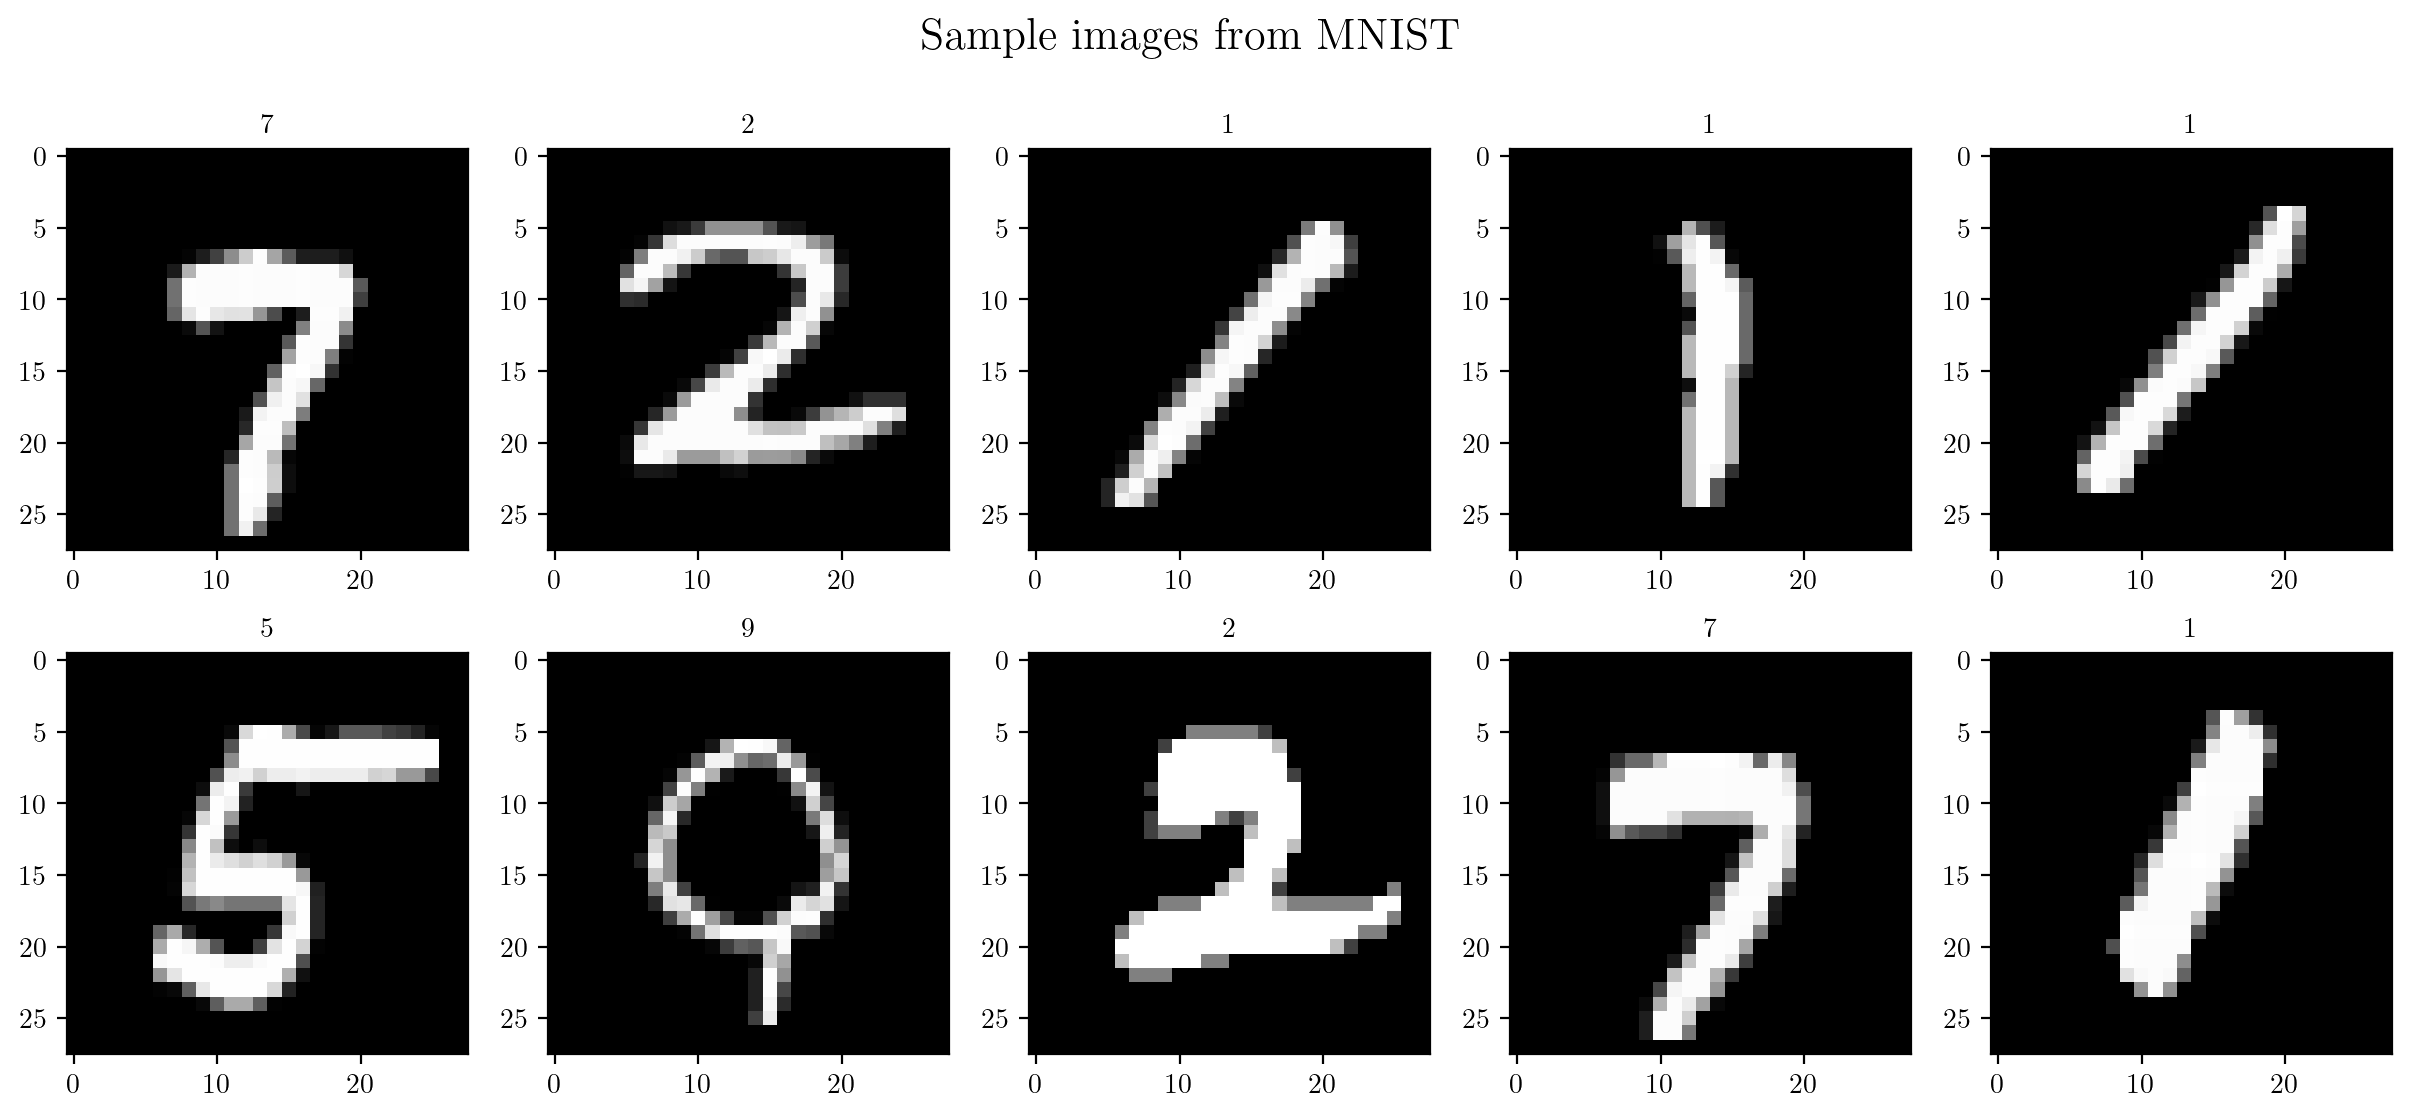

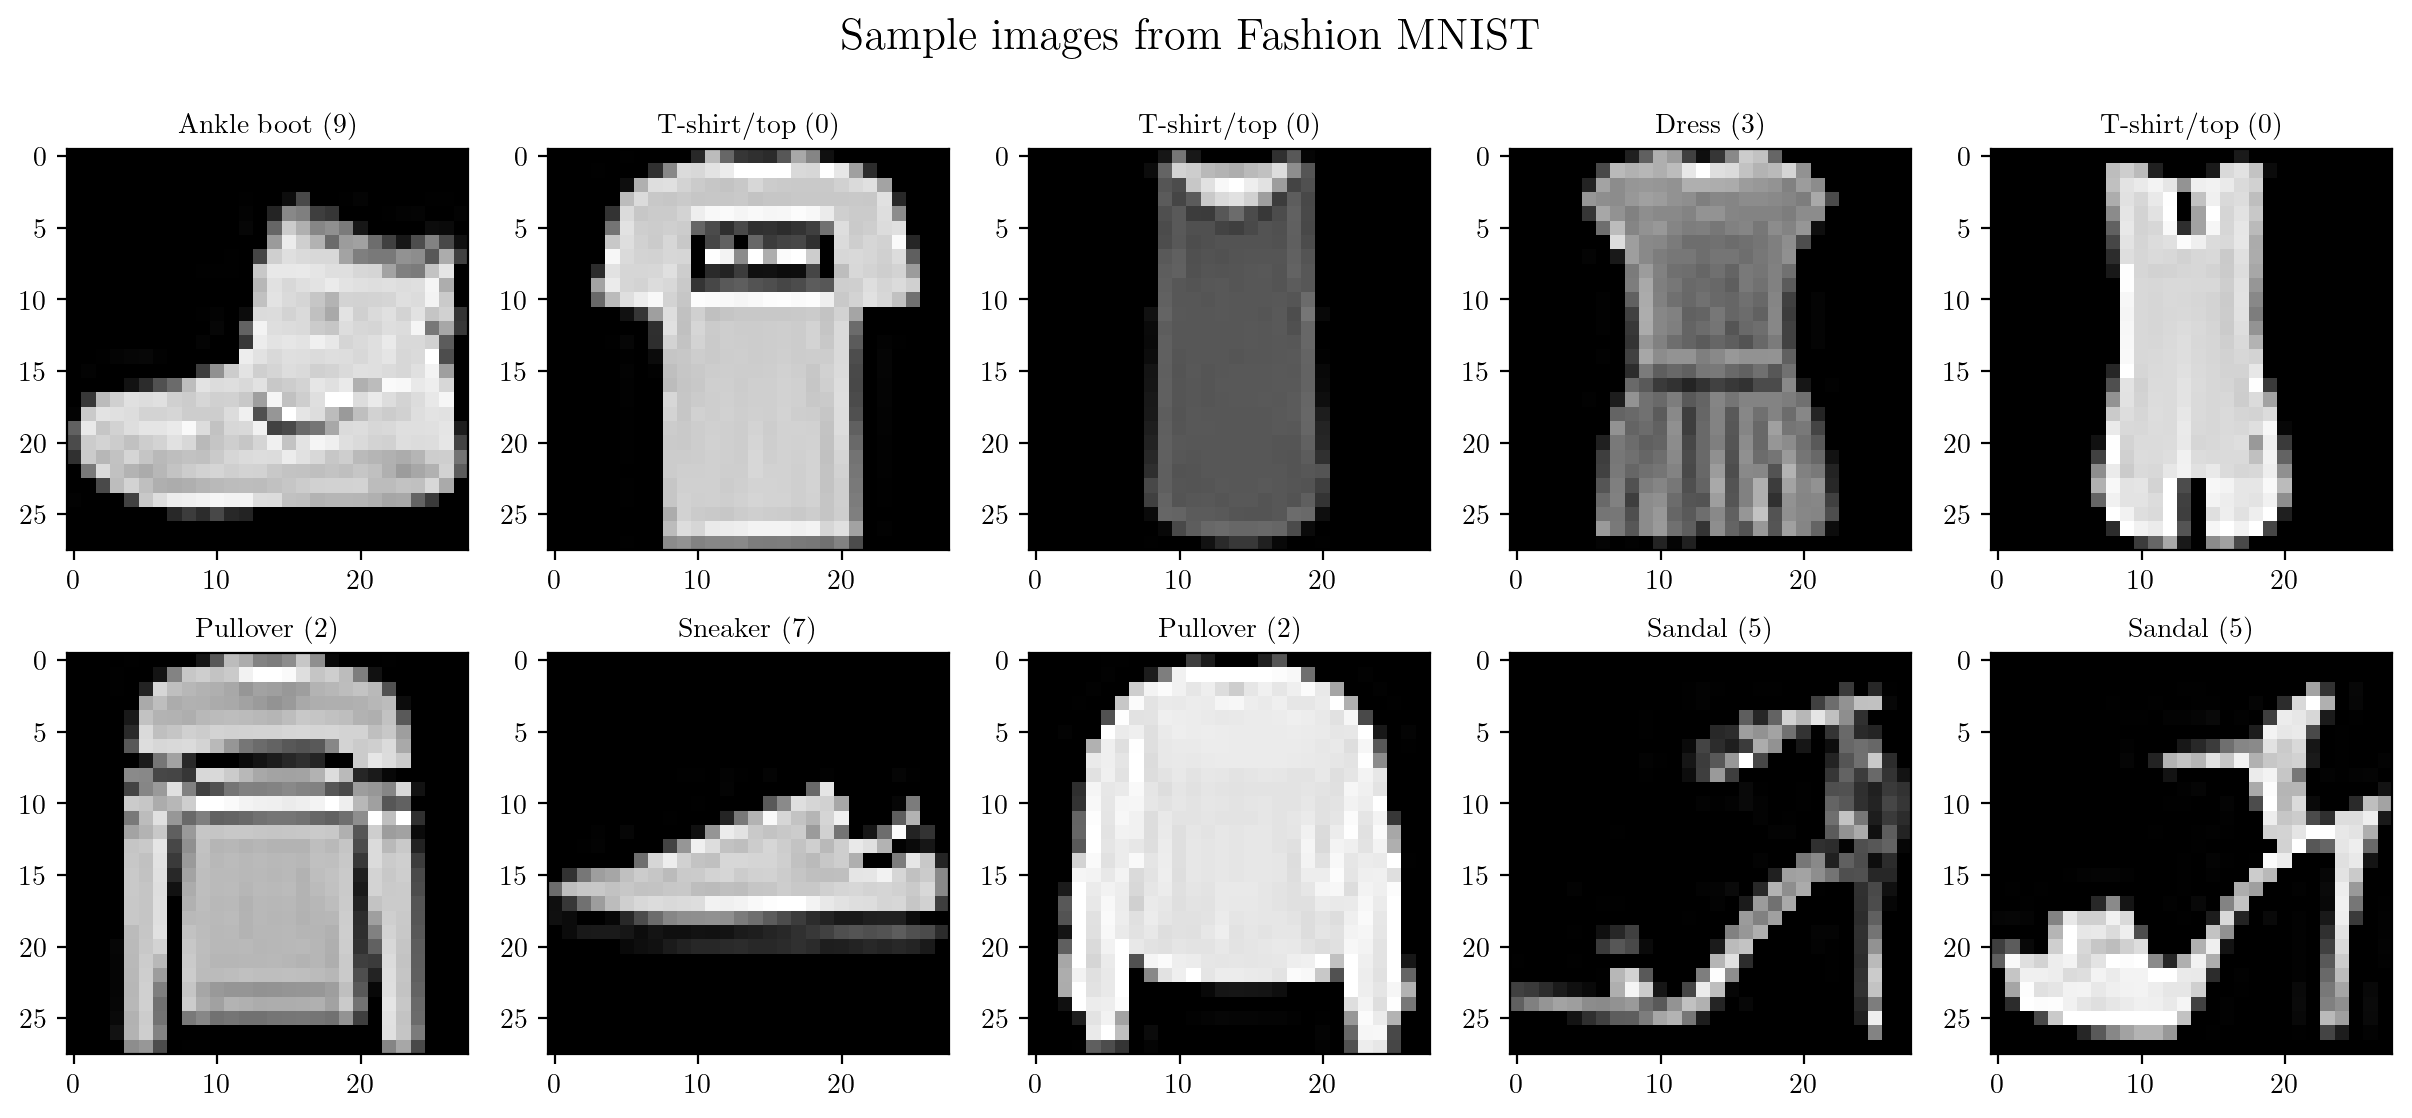

In [20]:
plot_images(mnist_train_loader, "MNIST", 10)
plot_images(fashion_loader, "Fashion MNIST", 10, label_mapping = fashion_mnist_labels)

## Model Architechture
### $$\text{Input Layer} = 784$$
### $$\text{Hidden Layer 1} = 30$$
### $$\text{Hidden Layer 2} = 20$$
### $$\text{Output Layer} = 10$$

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28*28, 30)
        self.lin2 = nn.Linear(30, 20)
        self.lin3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [22]:
model = MLP()
model = model.to(device)

In [23]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([30, 784])
lin1.bias torch.Size([30])
lin2.weight torch.Size([20, 30])
lin2.bias torch.Size([20])
lin3.weight torch.Size([10, 20])
lin3.bias torch.Size([10])


## Training the model

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 1000
print_every = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(mnist_train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % print_every == 0:
        average_loss = running_loss / len(mnist_train_loader)
        print(f"Epoch: {epoch} | Loss: {average_loss}")

Epoch: 0 | Loss: 0.42115490255293564
Epoch: 10 | Loss: 0.2384252741273596
Epoch: 20 | Loss: 0.21572462490785604
Epoch: 30 | Loss: 0.209226577669811
Epoch: 40 | Loss: 0.20519979536406266
Epoch: 50 | Loss: 0.20398166074927873
Epoch: 60 | Loss: 0.19990369384445106
Epoch: 70 | Loss: 0.19364416852756255
Epoch: 80 | Loss: 0.1943937728443602
Epoch: 90 | Loss: 0.20135150639030502
Epoch: 100 | Loss: 0.18656597736039396


KeyboardInterrupt: 

In [25]:
def predict(model, data_loader):
    predictions = []
    ground_truth = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.view(inputs.size(0), -1))
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            ground_truth.extend(labels.tolist())
    return predictions, ground_truth

In [26]:
def extract_features_labels(loader):
    features = []
    labels = []
    for images, targets in loader:
        features.append(images.view(images.size(0), -1).numpy())
        labels.append(targets.numpy())
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

train_features, train_labels = extract_features_labels(mnist_train_loader)
test_features, test_labels = extract_features_labels(mnist_test_loader)

train_features.shape, test_features.shape

((60000, 784), (10000, 784))

## Predictions from MLP, Logistic Regression, Random Forest

In [27]:
test_predictions, test_ground_truth = predict(model, mnist_test_loader)

lr_model = LogisticRegression(max_iter = 1000, random_state = 42)
lr_model.fit(train_features, train_labels)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(train_features, train_labels)

lr_predictions = lr_model.predict(test_features)
rf_predictions = rf_model.predict(test_features)

model_accuracy = accuracy_score(test_ground_truth, test_predictions)
lr_accuracy = accuracy_score(test_labels, lr_predictions)
rf_accuracy = accuracy_score(test_labels, rf_predictions)

model_f1 = f1_score(test_ground_truth, test_predictions, average = "weighted")
lr_f1 = f1_score(test_labels, lr_predictions, average = "weighted")
rf_f1 = f1_score(test_labels, rf_predictions, average = "weighted")

## Confusion Matrix for MLP

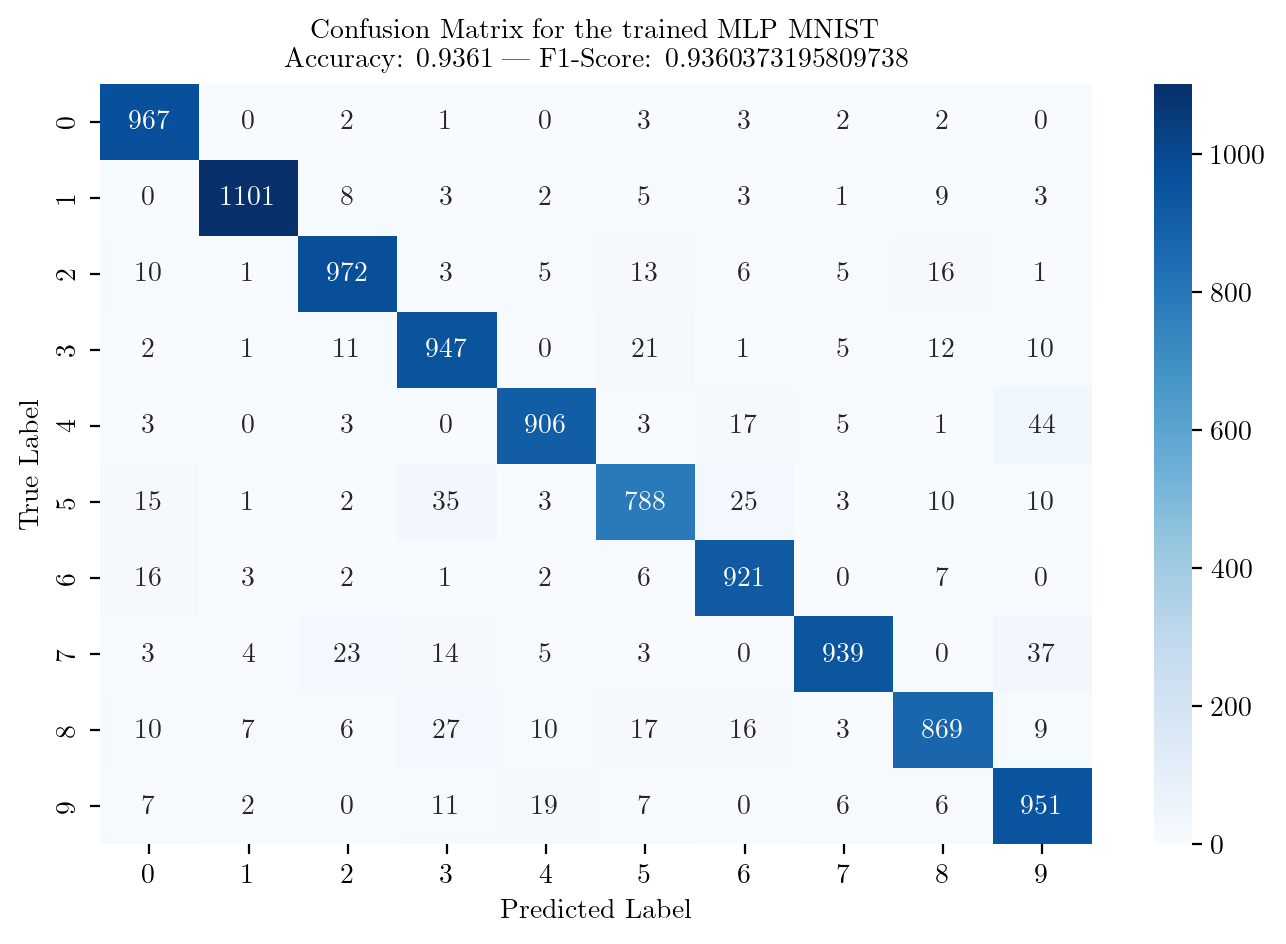

In [28]:
cm = confusion_matrix(test_ground_truth, test_predictions)
latexify(columns = 2, fig_width = 8)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = True)
plt.title("Confusion Matrix for the trained MLP MNIST" "\n" f"Accuracy: {model_accuracy} | F1-Score: {model_f1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Confusion Matrix for Logistic Regression Model

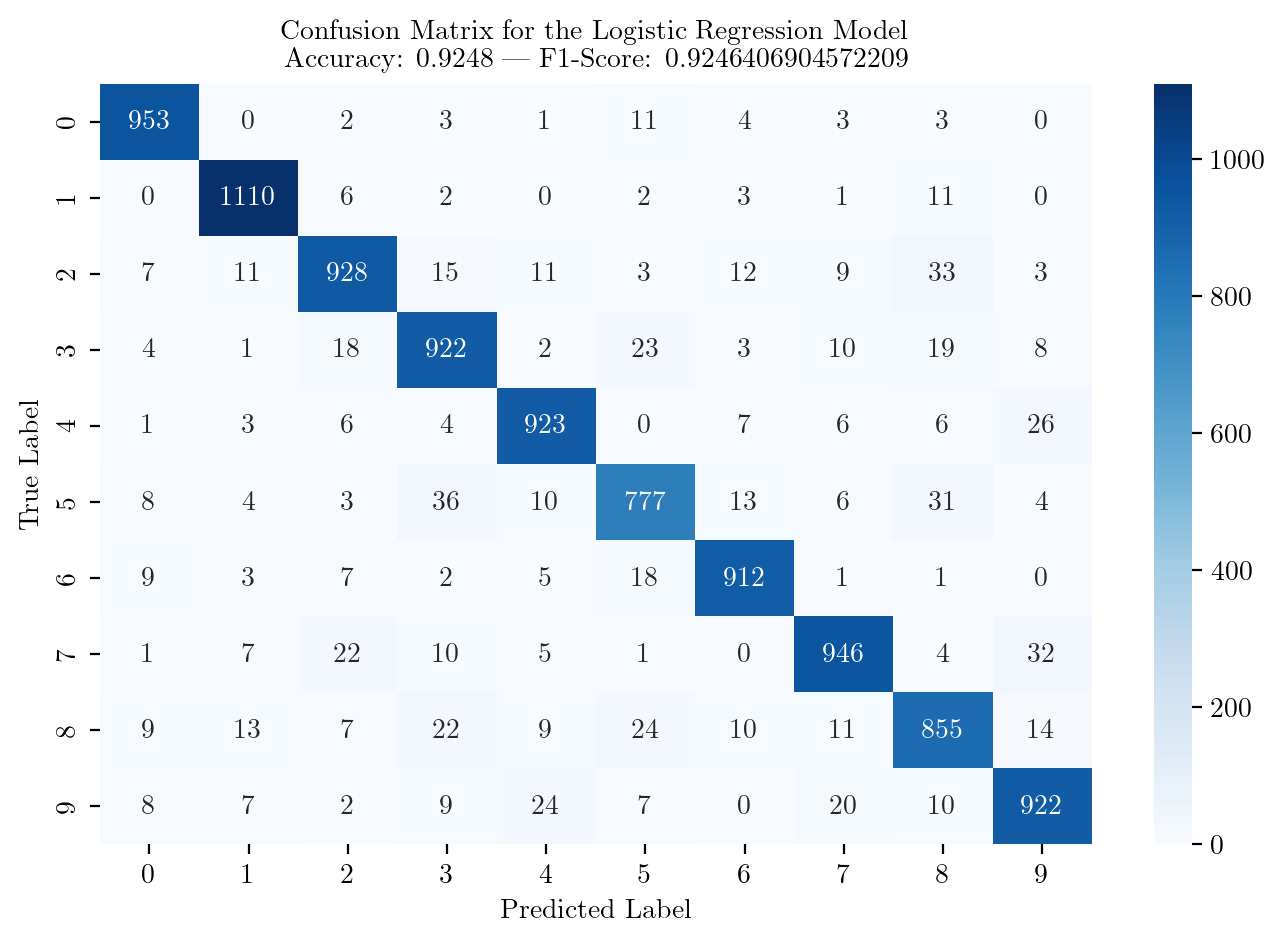

In [29]:
cm = confusion_matrix(test_labels, lr_predictions)
latexify(columns = 2, fig_width = 8)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = True)
plt.title("Confusion Matrix for the Logistic Regression Model" "\n" f"Accuracy: {lr_accuracy} | F1-Score: {lr_f1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Confusion Matrix for Random Forest Model

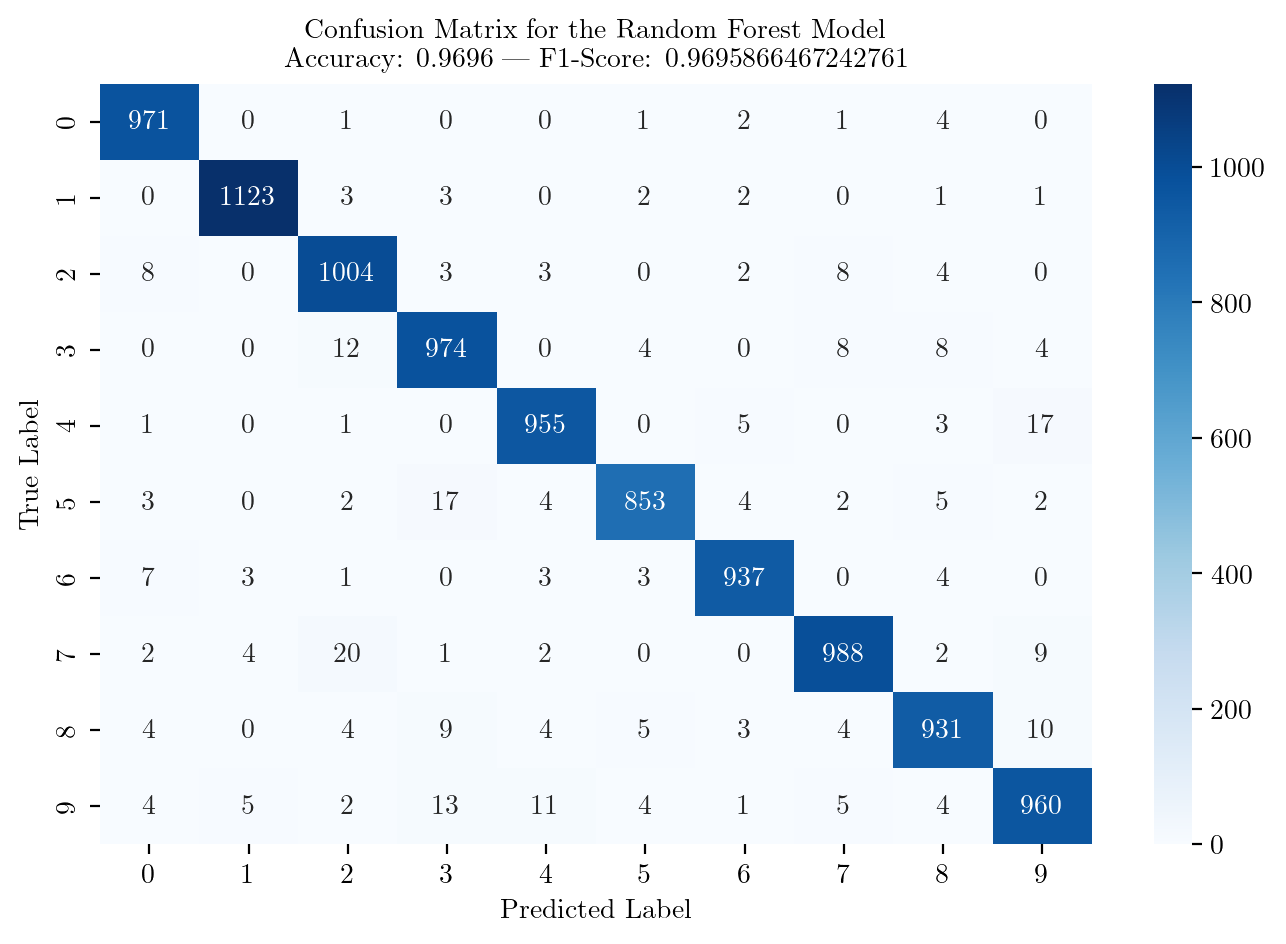

In [30]:
cm = confusion_matrix(test_labels, rf_predictions)
latexify(columns = 2, fig_width = 8)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = True)
plt.title("Confusion Matrix for the Random Forest Model" "\n" f"Accuracy: {rf_accuracy} | F1-Score: {rf_f1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Predictions for FashionMNIST

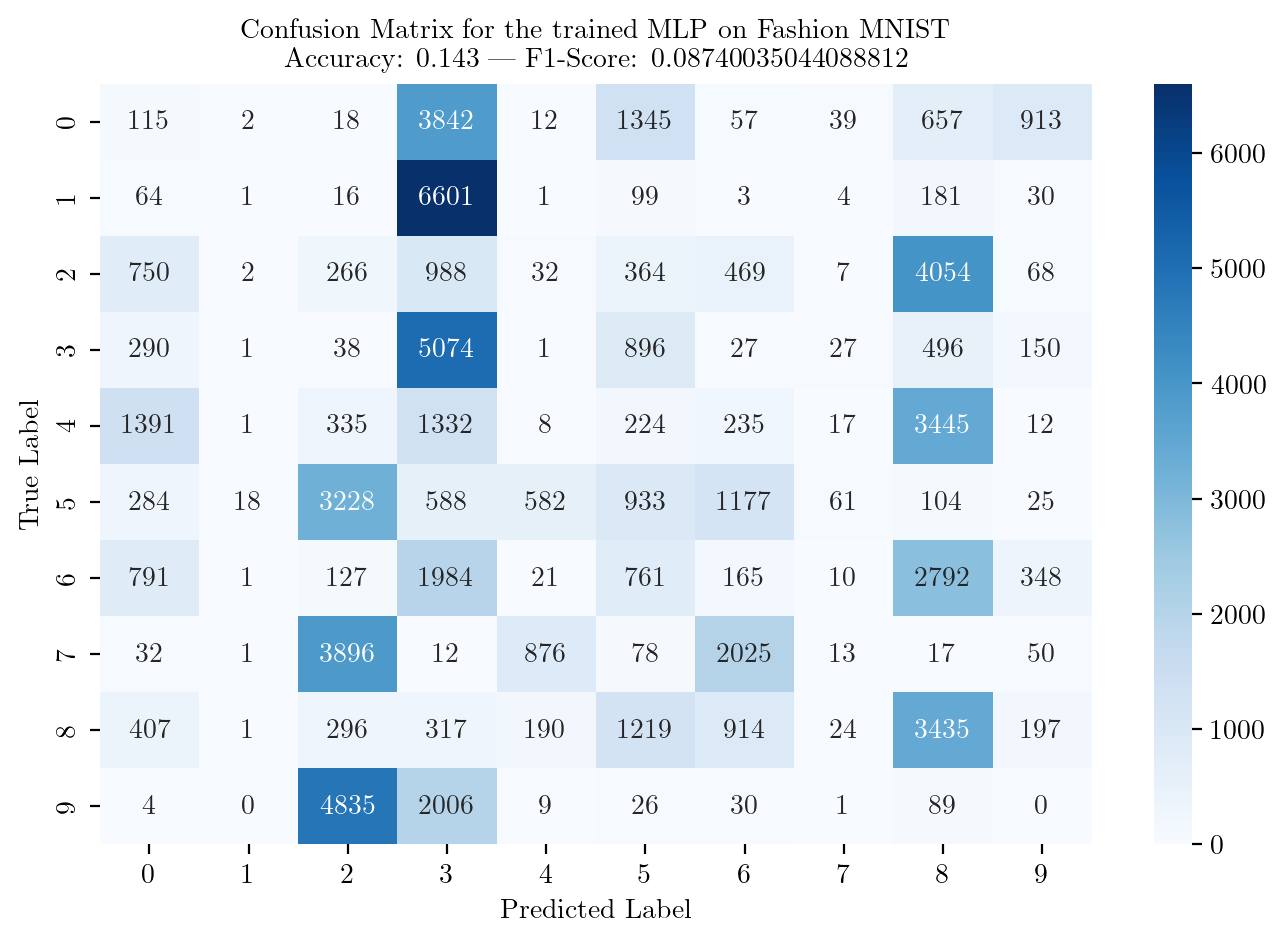

In [31]:
test_predictions, test_ground_truth = predict(model, fashion_loader)
Fmodel_f1 = f1_score(test_ground_truth, test_predictions, average = "weighted")
Fmodel_accuracy = accuracy_score(test_ground_truth, test_predictions)
cm = confusion_matrix(test_ground_truth, test_predictions)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = True)
plt.title("Confusion Matrix for the trained MLP on Fashion MNIST" "\n" f"Accuracy: {Fmodel_accuracy} | F1-Score: {Fmodel_f1}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Embeddings from the Second Layer $\text{Hidden Layer 2} = 20$

In [32]:
latexify(columns = 2)
def get_activations(model, data_loader):
    activations = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            x = model.lin1(inputs.view(inputs.size(0), -1))
            output = model.lin2(x)
            activations.append(output)
            labels.append(lbls)
    activations = torch.cat(activations).cpu().numpy()
    labels = torch.cat(labels).numpy()
    return activations, labels

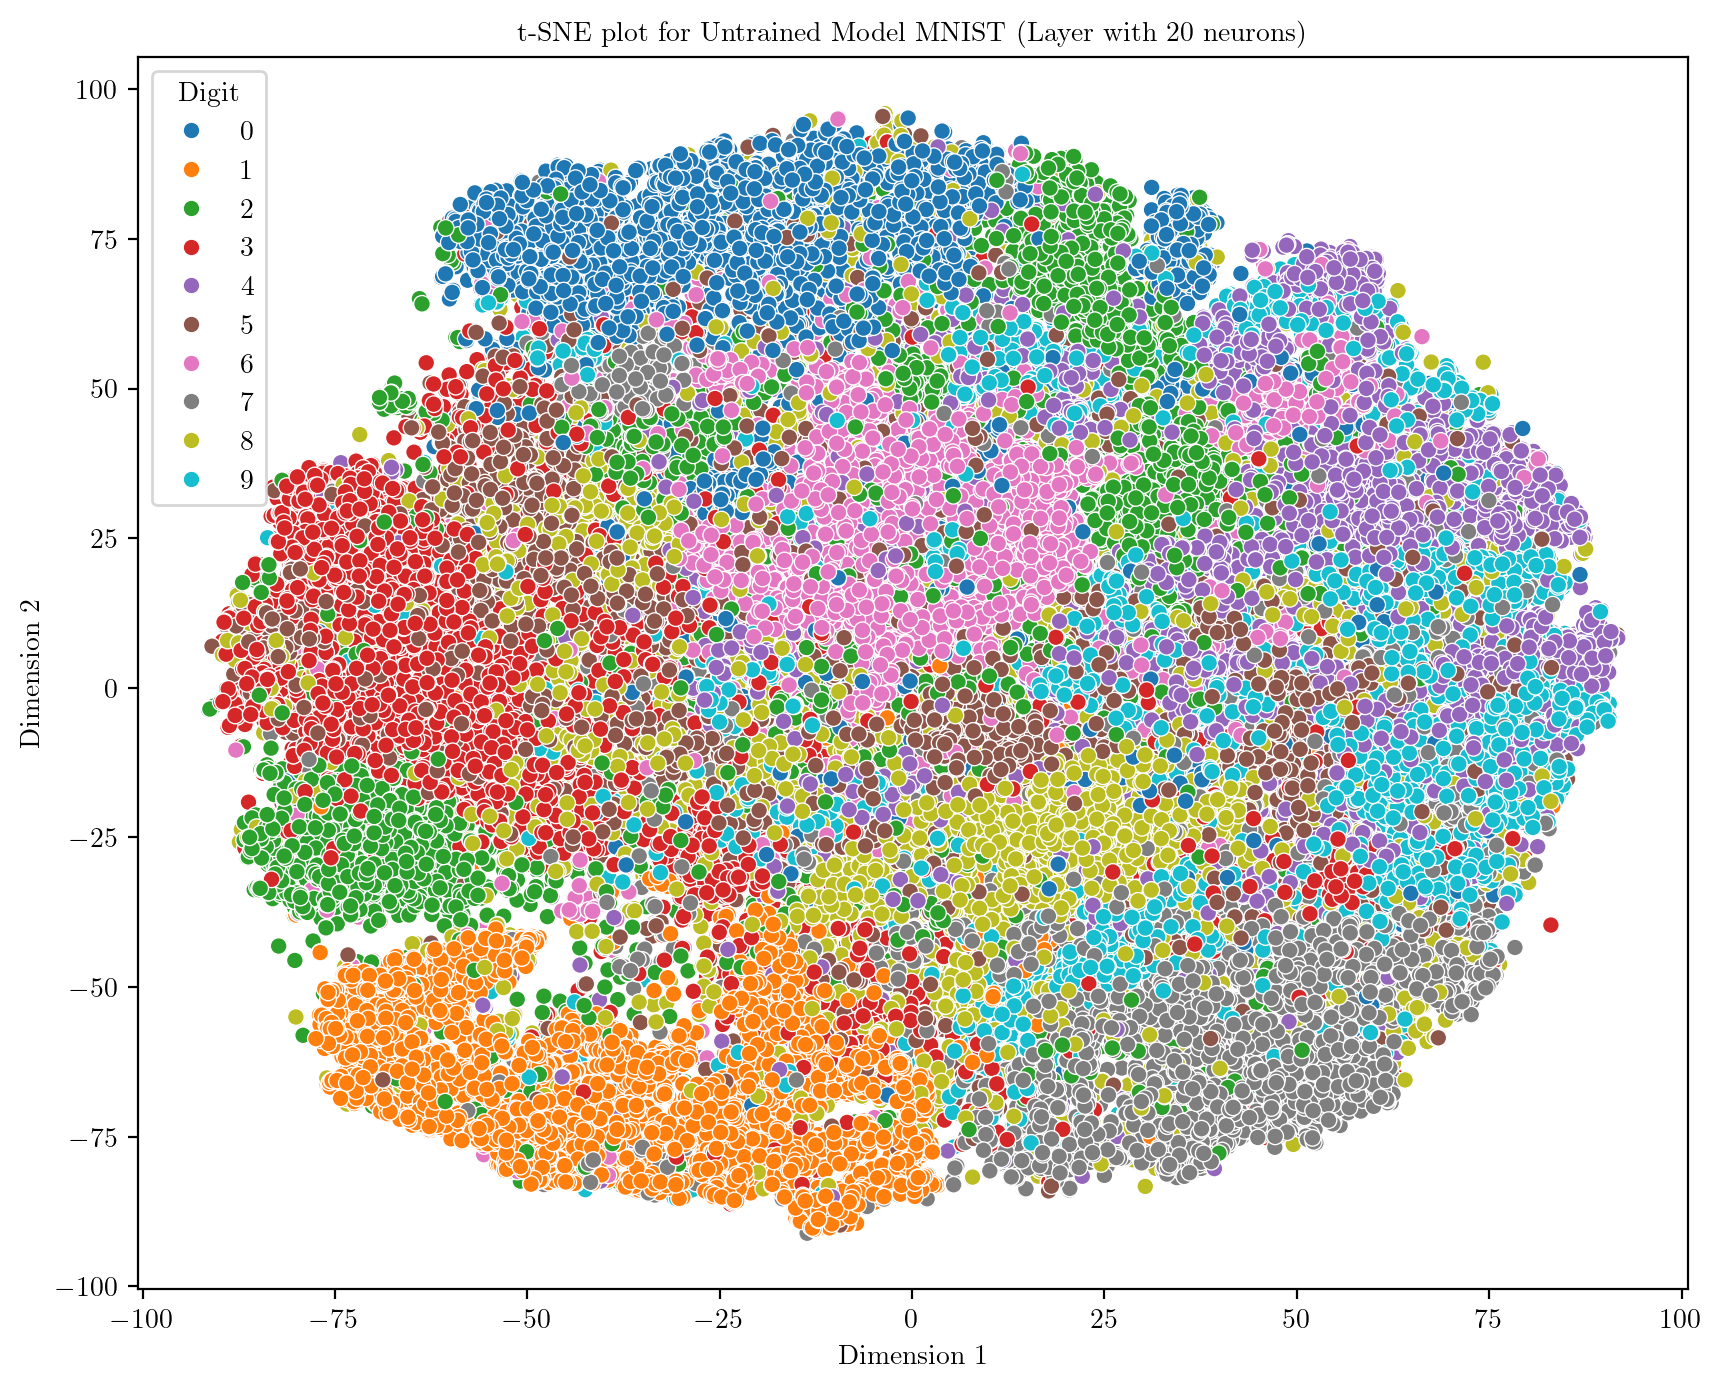

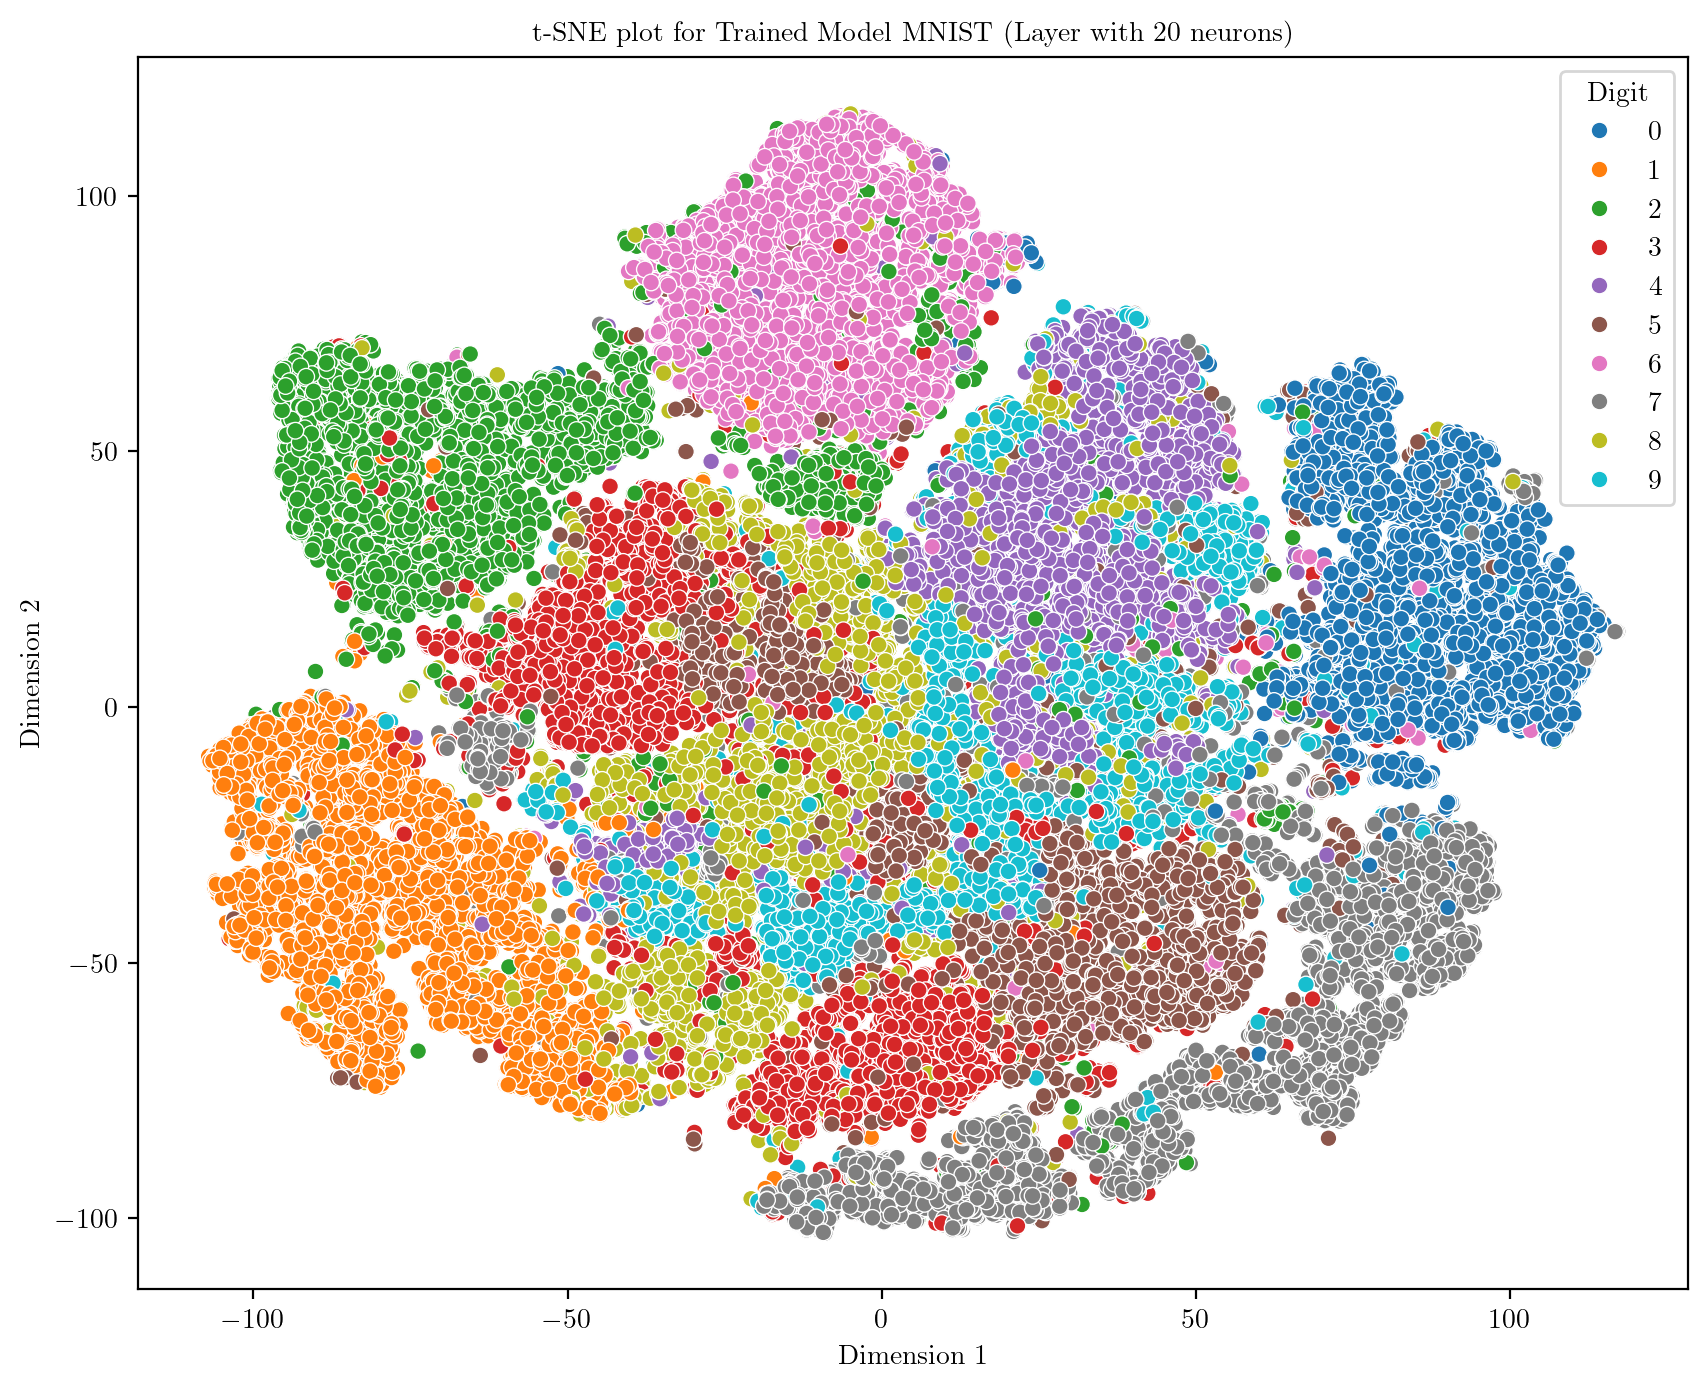

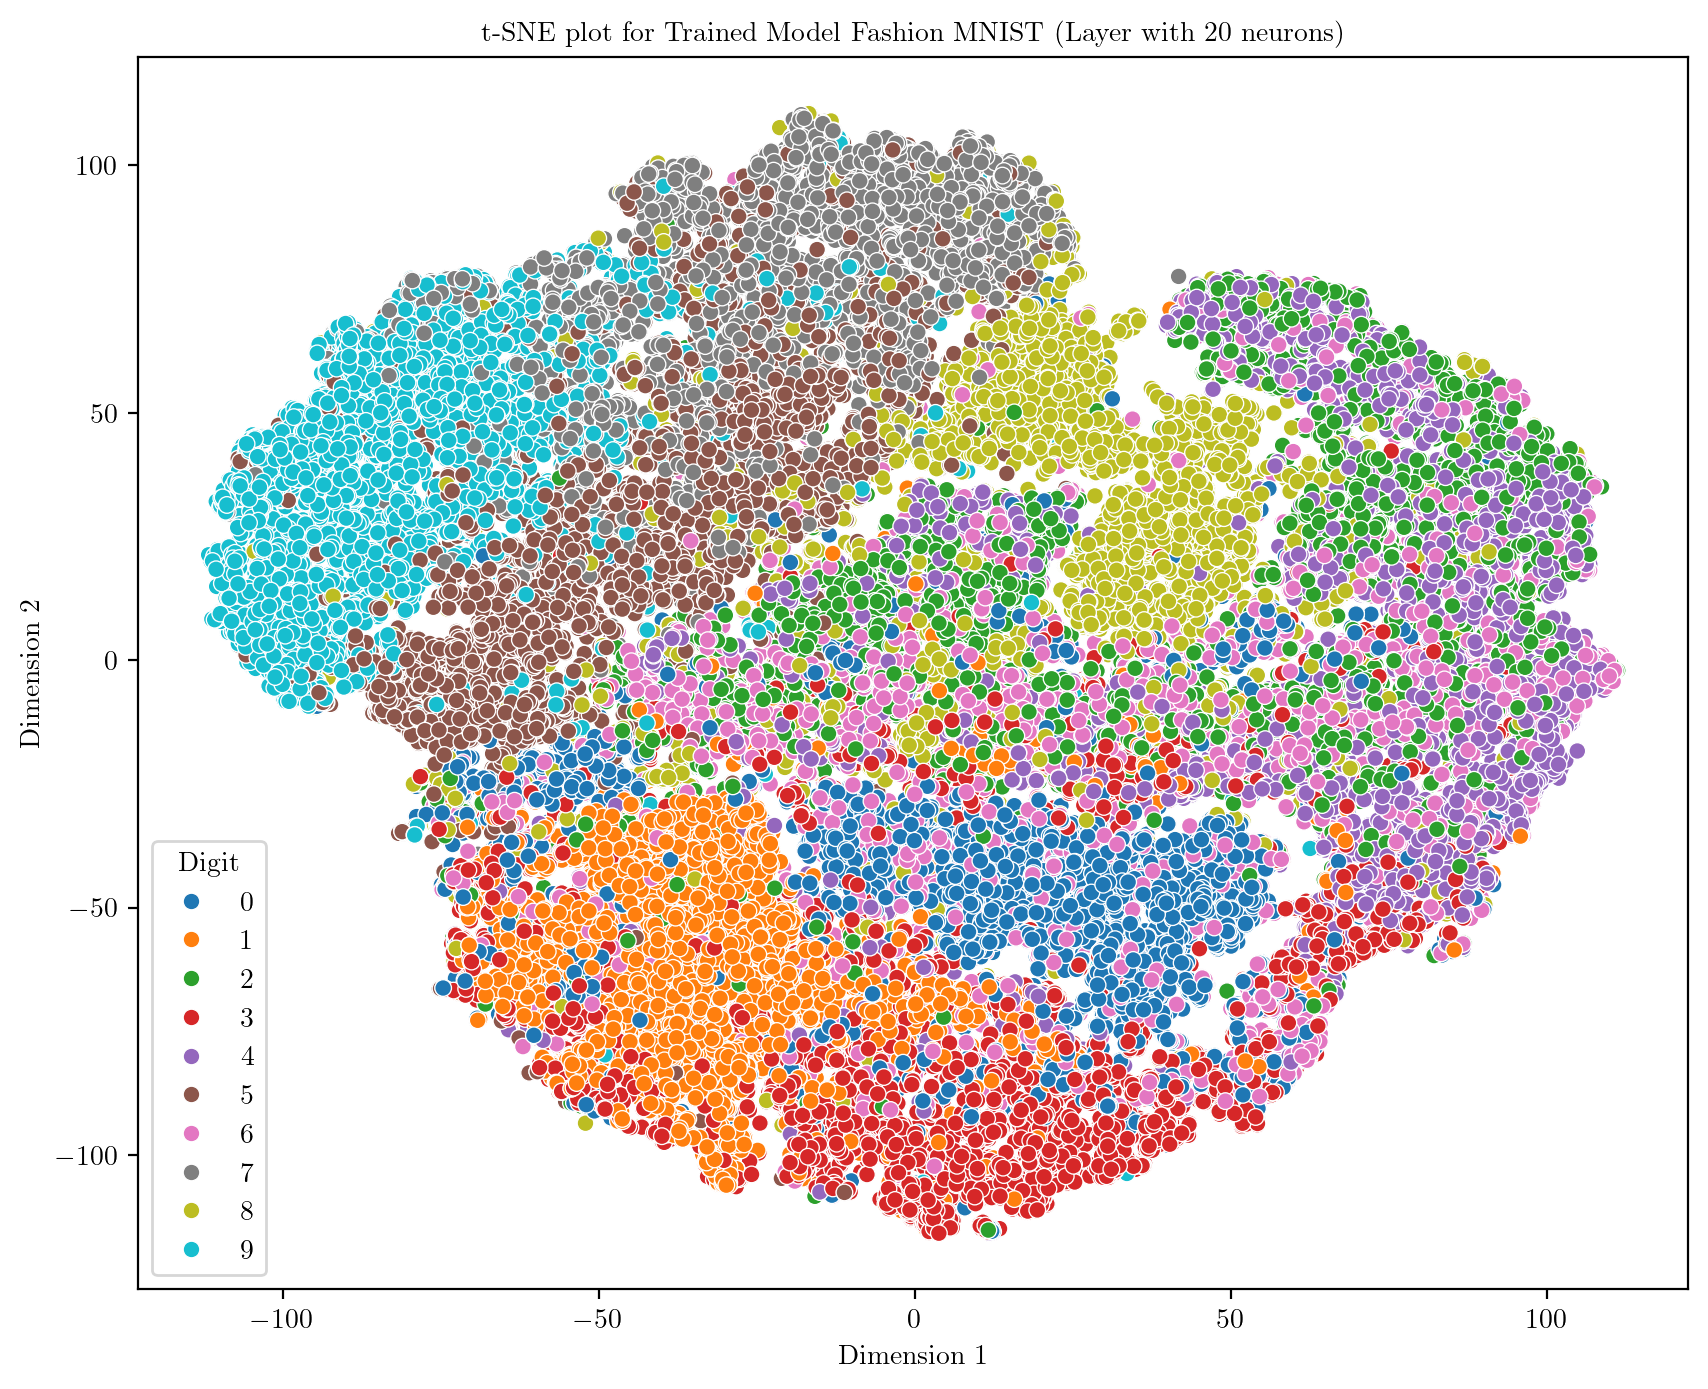

In [33]:
train_activations, train_labels = get_activations(MLP().to(device), mnist_train_loader)
tsne = TSNE(n_components = 2, random_state = 42)
train_tsne = tsne.fit_transform(train_activations)
plt.figure(figsize = (10, 8))
sns.scatterplot(x = train_tsne[:, 0], y = train_tsne[:, 1], hue = train_labels, palette = "tab10", legend = "full")
plt.title("t-SNE plot for Untrained Model MNIST (Layer with 20 neurons)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = "Digit")
plt.show()


train_activations, train_labels = get_activations(model, mnist_train_loader)
tsne = TSNE(n_components = 2, random_state = 42)
train_tsne = tsne.fit_transform(train_activations)
plt.figure(figsize = (10, 8))
sns.scatterplot(x = train_tsne[:, 0], y = train_tsne[:, 1], hue = train_labels, palette = "tab10", legend = "full")
plt.title("t-SNE plot for Trained Model MNIST (Layer with 20 neurons)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = "Digit")
plt.show()


activations, labels = get_activations(model, fashion_loader)

tsne = TSNE(n_components = 2, random_state = 42)
tsne = tsne.fit_transform(activations)
plt.figure(figsize = (10, 8))
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue = labels, palette = "tab10", legend = "full")
plt.title("t-SNE plot for Trained Model Fashion MNIST (Layer with 20 neurons)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = "Digit")
plt.show()